In [1]:
import numpy as np
import cv2 as cv2
import glob
"""
Using the fact that we have two cameras:
- Instead of triangulating new points in time, trinagulate new points in space: with a known baseline!
"""

# Params
MATCH_NUM = 400
IMG_PATH = '/exam_data/Question_32'
K = np.array([[7.188560e+02, 0.000000e+00, 6.071928e+02], [0, 7.188560e+02, 1.852157e+02], [0, 0, 1]])
BASELINE = 0.54
SHOW_IMG = True
# Specify img range(check dir)

def extract_keypoints_sift(img1, img2, K, baseline):
    """
    use sift to detect keypoint features
    remember to include a Lowes ratio test
    """
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1,None)
    kp2, des2 = sift.detectAndCompute(img2,None)
    
    matcher = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_FLANNBASED)
    knn_matches = matcher.knnMatch(des1, des2, 2)
    
    
    # Filter matches using the Lowe's ratio test
    ratio_thresh = 0.7
    good_matches = []
    for m,n in knn_matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)
            
    good_matches = sorted(good_matches, key = lambda x:x.distance)
    good_matches = good_matches[:MATCH_NUM]
    
    matchesTrainIdx = [x.trainIdx  for x in good_matches]
    matchesQueryIdx = [x.queryIdx  for x in good_matches]
   
    match_points1 = [kp1[i].pt for i in matchesQueryIdx]
    match_points2 = [kp2[i].pt for i in matchesTrainIdx]
    
    p1 = np.float32(np.array(match_points1))
    p2 = np.float32(np.array(match_points2))

    #project the feature points to 3D with triangulation
    
    M_left = K.dot(np.hstack((np.eye(3), np.zeros((3, 1)))))
    M_rght = K.dot(np.hstack((np.eye(3), np.array([[-baseline, 0, 0]]).T)))

    p1_flip = np.vstack((p1.T, np.ones((1, p1.shape[0]))))
    p2_flip = np.vstack((p2.T, np.ones((1, p2.shape[0]))))

    P = cv2.triangulatePoints(M_left, M_rght, p1_flip[:2], p2_flip[:2])

    # Normalize homogeneous coordinates (P->Nx4  [N,4] is the normalizer/scale)
    P = P / P[3]
    land_points = P[:3]

    return land_points.T, p1

def featureTracking(prev_img, next_img, prev_points, world_points):
    """
    Use OpenCV to find the prev_points from the prev_img in the next_img
    Remember to remove points that could not be found from prev_points, next_points, and world_points
    """
    params = dict(winSize=(21, 21),
                 maxLevel=3,
                 criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    
    
    next_points, status, _ = cv2.calcOpticalFlowPyrLK(prev_img, next_img, prev_points, nextPts=None, \
                                                      winSize=params["winSize"], maxLevel=params["maxLevel"], criteria=params["criteria"])
    
    next_points = np.squeeze(next_points[np.where(status[:,0]==1),:])
    prev_points = np.squeeze(prev_points[np.where(status[:,0]==1),:])
    world_points = np.squeeze(world_points[np.where(status[:,0]==1),:])
    
    return world_points, prev_points, next_points



In [2]:

images_left = glob.glob("exam_data\\Question_32\\left\\*.png")
images_right = glob.glob("exam_data\\Question_32\\right\\*.png")
# Get 3D points Using Triangulation
left_img = cv2.imread(images_left[0])
right_img = cv2.imread(images_right[0])
landmark_3D, reference_2D = extract_keypoints_sift(left_img, right_img, K, BASELINE)

# reference
prev_img = left_img
traj = np.zeros((left_img.shape[0]//2, 300, 3), dtype=np.uint8)
all_tvecs = []
# VO loop
for i in range(1, len(images_left)):
    curImage = cv2.imread(images_left[i])
    curImage_R = cv2.imread(images_right[i])

    # the 2D landmarks at the current time = t
    landmark_3D, reference_2D, tracked_2Dpoints = featureTracking(prev_img, 
                                                                    curImage, 
                                                                    reference_2D,
                                                                    landmark_3D)

    #Calculate relative pose using PNP: old landmark points, new 2D points
    _, rvec, tvec, _ = cv2.solvePnPRansac(landmark_3D,tracked_2Dpoints,K, None)

    rot, _ = cv2.Rodrigues(rvec)
    tvec = -rot.T.dot(tvec)  # coordinate transformation, from camera to world. What is the XYZ of the camera wrt World
    inv_transform = np.hstack((rot.T, tvec))  # inverse transform. A tranform projecting points from the camera frame to the world frame

    # re-obtain the 3D points
    landmark_3D_new, reference_2D_new = extract_keypoints_sift(curImage, curImage_R, K, BASELINE)
    
    #Project the points from camera to world coordinates
    reference_2D = reference_2D_new.astype('float32')
    # Apply the inverse transfor to get the landmark points; from camera->world.
    landmark_3D = inv_transform.dot(np.vstack((landmark_3D_new.T, np.ones((1, landmark_3D_new.shape[0])))))
    landmark_3D = landmark_3D.T

    prev_img = curImage

    # draw images
    draw_x, draw_y = int(tvec[0]) + 150, (left_img.shape[0]//2)-(int(tvec[2]) + 50);
    all_tvecs.append(tvec)

    print(f"\nImage: {i}\nPosition: {tvec.squeeze()}\nRotation: {rvec.squeeze()}")
    
    if SHOW_IMG:
        text = "Coordinates:\n x ={0:02f}m\n y = {1:02f}m\n z = {2:02f}m".format(float(tvec[0]), float(tvec[1]),
                                                                        float(tvec[2]))
        text = text.split('\n')
        text_frame = np.zeros((left_img.shape[0]//2, 300, 3), dtype=np.uint8);
        cv2.circle(traj, (draw_x, draw_y), 1, (0, 0, 255), 2)
        cv2.putText(text_frame, text[0], (10, 30), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8)
        cv2.putText(text_frame, text[1], (10, 60), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8)
        cv2.putText(text_frame, text[2], (10, 90), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8)
        cv2.putText(text_frame, text[3], (10, 120), cv2.FONT_HERSHEY_PLAIN, 1, (255, 255, 255), 1, 8)
        
        vis = np.vstack((text_frame, traj))
        vis = np.hstack((curImage, vis))
        
        cv2.imshow("Trajectory", vis)
        k = cv2.waitKey(1) & 0xFF
        if k == 27: break
print(f"\n\n======= Results ======= \nPosition: {tvec.squeeze()}\nRotation: {rvec.squeeze()}")
cv2.destroyAllWindows()


Image: 1
Position: [-0.01313607 -0.01590476  0.62714445]
Rotation: [0.00312628 0.00040458 0.00172359]

Image: 2
Position: [-0.02102235 -0.02529324  1.22702576]
Rotation: [ 0.00588098  0.00278768 -0.00029554]

Image: 3
Position: [-0.02036752 -0.0373093   1.80523952]
Rotation: [ 0.00552874  0.00773424 -0.00639171]

Image: 4
Position: [-0.02993559 -0.05447922  2.35317525]
Rotation: [ 0.00372318  0.01564516 -0.00989172]

Image: 5
Position: [-0.0450245  -0.06760465  2.88973718]
Rotation: [ 7.21899804e-05  2.65735308e-02 -1.21261420e-02]

Image: 6
Position: [-0.08270705 -0.07919753  3.41118717]
Rotation: [-0.0033789   0.04047783 -0.0124047 ]

Image: 7
Position: [-0.12857634 -0.09284384  3.91430827]
Rotation: [-0.00546592  0.05922735 -0.01242691]

Image: 8
Position: [-0.18316323 -0.10410851  4.41897959]
Rotation: [-0.00413157  0.08109214 -0.0155906 ]

Image: 9
Position: [-0.25751165 -0.11871543  4.91905382]
Rotation: [-0.00105567  0.10556468 -0.01269943]

Image: 10
Position: [-0.3435946  -0.

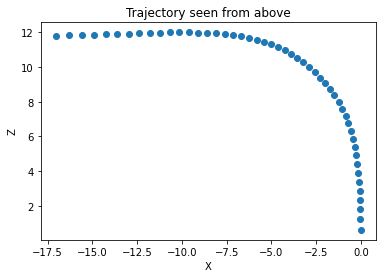

In [3]:
import matplotlib.pyplot as plt
all_tvecs = np.array(all_tvecs)
plt.scatter(all_tvecs[:, 0], all_tvecs[:, 2])
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Trajectory seen from above");